In [1]:
import pandas as pd
import numpy as np
import scipy.stats as scipy
import matplotlib.pyplot as plt
import urllib.request #download from football data
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import voting_classifier
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier

c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def load19():
	urllib.request.urlretrieve("http://www.football-data.co.uk/mmz4281/1819/E0.csv",
	 "./Data/England/E0_19.csv")

def transformResult(row):
    '''Converts results (H,A or D) into numeric values'''
    if(row.FTR == 'H'):
        return 1
    elif(row.FTR == 'A'):
        return -1
    else:
        return 0

In [3]:
"""load data"""
loc = "C:/Users/Naomi/Desktop/personal/Locker/ML_project/research/epl-prediction-2017"
df1 = pd.read_csv( loc + "/Data/England/10-11.csv")
df2 = pd.read_csv(loc + "/Data/England/11-12.csv")
df3 = pd.read_csv(loc + "/Data/England/12-13.csv")
df4 = pd.read_csv(loc + "/Data/England/13-14.csv")
df5 = pd.read_csv(loc + "/Data/England/14-15.csv")
df6 = pd.read_csv(loc + "/Data/England/15-16.csv")
df7 = pd.read_csv(loc + "/Data/England/16-17.csv")
df8 = pd.read_csv(loc + "/Data/England/17-18.csv")
df9 = pd.read_csv(loc + "/Data/England/18-19.csv")
df = pd.concat([df1, df2, df2, df3, df4, df5, df6, df7, df8],
                ignore_index=True, sort=False)

In [4]:
"""

clean data

"""
res_18 = df.ix[:,:23]
res_18 = res_18.drop(['Div','Date'],axis=1)
# res_14 = df_14.ix[:,:23]
# res_14 = res_14.drop(['Div','Date'],axis=1)
table_features = df.ix[:,:7]
table_features = table_features.drop(['FTHG',
	'FTAG','Div','Date'],axis=1)
bet_16 = df.ix[:,23:]
feature_table = df.ix[:,:23]

c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/in

In [5]:
#Team, Home Goals Score, Away Goals Score, Attack Strength, Home Goals Conceded, Away Goals Conceded, Defensive Strength
table_18 = pd.DataFrame(columns=('Team','HGS','AGS',
	'HAS','AAS','HGC','AGC','HDS','ADS',))

avg_home_scored_18 = res_18.FTHG.sum()*1.0 / res_18.shape[0]
avg_away_scored_18 = res_18.FTAG.sum()*1.0 / res_18.shape[0]
avg_home_conceded_18 = avg_away_scored_18
avg_away_conceded_18 = avg_home_scored_18
res_home = res_18.groupby('HomeTeam')
res_away = res_18.groupby('AwayTeam')

table_18.Team = res_home.HomeTeam.apply(pd.DataFrame).columns.values
table_18.HGS = res_home.FTHG.sum().values
table_18.HGC = res_home.FTAG.sum().values
table_18.AGS = res_away.FTAG.sum().values
table_18.AGC = res_away.FTHG.sum().values
#Assuming number of home games = number of away games
num_games = res_18.shape[0]/20
'''
HGC = Home Goals Conceeded
AGC = Away goals conceeded
'''
table_18.HAS = (table_18.HGS / num_games) / avg_home_scored_18
table_18.AAS = (table_18.AGS / num_games) / avg_away_scored_18
table_18.HDS = (table_18.HGC / num_games) / avg_home_conceded_18
table_18.ADS = (table_18.AGC / num_games) / avg_away_conceded_18

''' feature_table contains all the fixtures in the current season.
ftr = full time result
hst = home shots on target
ast = away shots on target
'''


c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\groupby\groupby.py:1105: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


' feature_table contains all the fixtures in the current season.\nftr = full time result\nhst = home shots on target\nast = away shots on target\n'

In [6]:
feature_table = feature_table[['HomeTeam','AwayTeam','FTR','HST','AST']]
f_HAS = []
f_HDS = []
f_AAS = []
f_ADS = []

for index,row in feature_table.iterrows():
    try:
        f_HAS.append(table_18[table_18['Team'] == row['HomeTeam']]['HAS'].values[0])
        f_HDS.append(table_18[table_18['Team'] == row['HomeTeam']]['HDS'].values[0])
        f_AAS.append(table_18[table_18['Team'] == row['AwayTeam']]['AAS'].values[0])
        f_ADS.append(table_18[table_18['Team'] == row['AwayTeam']]['ADS'].values[0])
    except:
        f_HAS.append(0)
        f_HDS.append(0)
        f_AAS.append(0)
        f_ADS.append(0)
        
    
feature_table['HAS'] = f_HAS
feature_table['HDS'] = f_HDS
feature_table['AAS'] = f_AAS
feature_table['ADS'] = f_ADS

feature_table["Result"] = feature_table.apply(lambda row: transformResult(row),axis=1)


In [7]:
def get_team_progress(df, team):
    df = df[(df.HomeTeam == team) | (df.AwayTeam == team)]
    data = np.array(df)
    progress = []
    for row in data:
        if row[0] == team:
            if row[2] == 'H':
                progress.append("W")
            elif row[2] == 'D':
                progress.append("D")
            elif row[2] == 'A':
                progress.append("L")

        elif row[1] == team:
            if row[2] == 'A':
                progress.append("W")
            elif row[2] == 'D':
                progress.append("D")
            elif row[2] == 'H':
                progress.append("L")

    return progress
    
def get_team_loosing_streak(team_prog):
    team_loosing_streak = 0
    tmp = 0

    for i in team_prog:
        if i == "L":
            tmp += 1
        else:
            if tmp > team_loosing_streak:
                team_loosing_streak = tmp
                tmp = 0
            else:
                tmp = 0

    return team_loosing_streak

def get_team_Drawing_streak(team_prog):
    team_loosing_streak = 0
    tmp = 0

    for i in team_prog:
        if i == "D":
            tmp += 1
        else:
            if tmp > team_loosing_streak:
                team_loosing_streak = tmp
                tmp = 0
            else:
                tmp = 0

    return team_loosing_streak

def get_team_Winning_streak(team_prog):
    team_loosing_streak = 0
    tmp = 0

    for i in team_prog:
        if i == "W":
            tmp += 1
        else:
            if tmp > team_loosing_streak:
                team_loosing_streak = tmp
                tmp = 0
            else:
                tmp = 0

    return team_loosing_streak

def get_form_points(team_prog):
    point = 0
    for result in team_prog:
        if result == 'W':
            point += 3
        elif result == 'D':
            point +=1
            
    return point

#WS = winning streak
#LS = loosing streak
#DS = draing streak


In [8]:
feature_table.head()

,HomeTeam,AwayTeam,FTR,HST,AST,HAS,HDS,AAS,ADS,Result
0,Aston Villa,West Ham,H,11.0,2.0,0.536485,0.915805,0.723781,0.840368,1
1,Blackburn,Everton,H,2.0,12.0,0.277621,0.403742,0.935500,0.874132,1
2,Bolton,Fulham,D,9.0,7.0,0.300131,0.502216,0.398818,0.551491,0
3,Chelsea,West Brom,H,13.0,4.0,1.343088,0.787789,0.827179,1.005440,1
4,Sunderland,Birmingham,D,2.0,7.0,0.649034,0.925652,0.088626,0.135059,0


In [9]:
"""

Adding recent performance


"""

feat_table = res_18.sort_index(ascending=False)
feat_table = feat_table[['HomeTeam','AwayTeam','FTR',
'FTHG','FTAG','HS','AS','HC','AC']]

# Adding next week fixtures
new_fixtures = pd.DataFrame( [['Chelsea','Man City','D',0,0,0,0,0,0],
                             ['Liverpool','Bournemouth','D',0,0,0,0,0,0],
                             ['Southampton','Crystal Palace','D',0,0,0,0,0,0],
                             ['Hull','Middlesbrough','D',0,0,0,0,0,0],
                             ['Arsenal','West Ham','D',0,0,0,0,0,0],
                             ['Swansea','Tottenham','D',0,0,0,0,0,0],
                             ['Man United','Everton','D',0,0,0,0,0,0],
                             ['Leicester','Sunderland','D',0,0,0,0,0,0],
                             ['Burnley','Stoke','D',0,0,0,0,0,0],
                             ['Watford','West Brom','D',0,0,0,0,0,0]],columns=feat_table.columns)

new_feat_table = new_fixtures.append(feat_table,ignore_index=True)
new_feat_table = new_feat_table.sort_index(ascending=False)
new_feat_table = new_feat_table.reset_index().drop(['index'], axis=1)
new_feat_table = new_feat_table.sort_index(ascending=False)
# feat_table = n
feat_table = new_feat_table

#Adding k recent performance measures
feat_table["pastHS"] = 0.0
feat_table["pastHC"] = 0.0
feat_table["pastAS"] = 0.0
feat_table["pastAC"] = 0.0
feat_table["pastHG"] = 0.0
feat_table["pastAG"] = 0.0
feat_table["intHT"] = 0
feat_table["intAT"] = 0

# Adding k recent performance metrics. Change value of k.
k = 4
for i in range(feat_table.shape[0]-1,-1,-1):
    row = feat_table.loc[i]
    ht = row.HomeTeam
    at = row.AwayTeam
    ht_stats = feat_table.loc[i-1:-1][(feat_table.HomeTeam == ht) | (feat_table.AwayTeam == ht)].head(k)
    at_stats = feat_table.loc[i-1:-1][(feat_table.HomeTeam == at) | (feat_table.AwayTeam == at)].head(k)

    feat_table.set_value(i, 'pastHC', (ht_stats[ht_stats["AwayTeam"] == ht].sum().HC + 
                                       ht_stats[ht_stats["HomeTeam"] == ht].sum().HC)/k)
    feat_table.set_value(i, 'pastAC', (at_stats[at_stats["AwayTeam"] == at].sum().HC +
                                       at_stats[at_stats["HomeTeam"] == at].sum().HC)/k)
    feat_table.set_value(i, 'pastHS', (ht_stats[ht_stats["AwayTeam"] == ht].sum().HS +
                                       ht_stats[ht_stats["HomeTeam"] == ht].sum().AS)/k)
    feat_table.set_value(i, 'pastAS', (at_stats[at_stats["AwayTeam"] == at].sum().HS +
                                       at_stats[at_stats["HomeTeam"] == at].sum().AS)/k)
    feat_table.set_value(i, 'pastHG', (ht_stats[ht_stats["AwayTeam"] == ht].sum().FTAG +
                                       ht_stats[ht_stats["HomeTeam"] == ht].sum().FTHG)/k)
    feat_table.set_value(i, 'pastAG', (at_stats[at_stats["AwayTeam"] == at].sum().FTAG +
                                       at_stats[at_stats["HomeTeam"] == at].sum().FTHG)/k)


c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .a

In [10]:
len(df)

3421

In [11]:

def team_to_int(df, team):
    teams = df.Team
    for i in range(len(teams)):
        if team == teams[i]:
            return i
f_HAS = []
f_HDS = []
f_AAS = []
f_ADS = []
for index,row in feat_table.iterrows():
    try:
        f_HAS.append((table_18[table_18['Team'] == row['HomeTeam']]['HAS'].values)[0])
        f_HDS.append((table_18[table_18['Team'] == row['HomeTeam']]['HDS'].values)[0])
        f_AAS.append((table_18[table_18['Team'] == row['HomeTeam']]['AAS'].values)[0])
        f_ADS.append((table_18[table_18['Team'] == row['HomeTeam']]['ADS'].values)[0])
    except:
        f_HAS.append(0)
        f_HDS.append(0)
        f_AAS.append(0)
        f_ADS.append(0)    

feat_table['HAS'] = f_HAS
feat_table['HDS'] = f_HDS
feat_table['AAS'] = f_AAS
feat_table['ADS'] = f_ADS

test_table = feat_table.drop(['FTHG','FTAG','HS','AS','HC','AC'],axis=1)
test_table["Result"] = test_table.apply(lambda row: transformResult(row),axis=1)
test_table.sort_index(inplace=True)

"""


Adding home advantage


"""
test_table["pastCornerDiff"] = (test_table["pastHC"] - test_table["pastAC"])/k
test_table["pastGoalDiff"] = (test_table["pastHG"] - test_table["pastAG"])/k
test_table["pastShotsDiff"] = (test_table["pastHS"] - test_table["pastAG"])/k


In [12]:
feat_table[feat_table.notnull()].head()

,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HS,AS,HC,AC,pastHS,...,pastAS,pastAC,pastHG,pastAG,intHT,intAT,HAS,HDS,AAS,ADS
3430,Chelsea,Man City,D,0.0,0.0,0.0,0.0,0.0,0.0,9.75,...,5.75,3.75,0.75,2.00,0,0,1.343088,0.787789,1.309700,0.701557
3429,Liverpool,Bournemouth,D,0.0,0.0,0.0,0.0,0.0,0.0,8.00,...,12.75,7.75,1.50,1.00,0,0,1.215532,0.738552,1.368784,0.919152
3428,Southampton,Crystal Palace,D,0.0,0.0,0.0,0.0,0.0,0.0,11.75,...,8.50,4.25,1.00,2.25,0,0,0.641531,0.635155,0.605613,0.581504
3427,Hull,Middlesbrough,D,0.0,0.0,0.0,0.0,0.0,0.0,13.50,...,20.50,5.25,0.25,0.75,0,0,0.251360,0.393895,0.201871,0.390171
3426,Arsenal,West Ham,D,0.0,0.0,0.0,0.0,0.0,0.0,15.00,...,15.50,3.75,2.00,1.50,0,0,1.346839,0.709010,1.418021,0.907897


In [13]:

''' number of games to exclude in the training set for validation
For example, if 240 games have been played, test_table has 250 fixtures - the last 10 being the ones that haven't
been played. So, we set aside 20 fixtures from the training set(240 fixtures) for validation.''' 
from sklearn.preprocessing import StandardScaler

test_table.drop(['pastHC','pastAS','pastAC','pastHG','pastAG'],axis=1)
scaler = StandardScaler()
scaler.fit(test_table[['pastCornerDiff','pastGoalDiff','pastShotsDiff','HAS','HDS','AAS','ADS']])
num_games = feat_table.shape[0]-10
v_split = 20
n_games = num_games - v_split

X_all = scaler.transform(test_table[['pastCornerDiff','pastGoalDiff','pastShotsDiff','HAS','HDS','AAS','ADS']])
X_train = scaler.transform(test_table[['pastCornerDiff','pastGoalDiff','pastShotsDiff','HAS','HDS','AAS','ADS']].loc[0:n_games])
y_train = test_table['Result'].loc[0:n_games]
X_test = scaler.transform(test_table[['pastCornerDiff','pastGoalDiff','pastShotsDiff','HAS','HDS','AAS','ADS']].loc[n_games:num_games-1])
y_test = test_table['Result'].loc[n_games:num_games-1]
X_predict = scaler.transform(test_table[['pastCornerDiff','pastGoalDiff',
                                         'pastShotsDiff','HAS','HDS','AAS','ADS']].loc[num_games:])


In [14]:
len(X_train)

3402

In [15]:
clf1 = RandomForestClassifier()
clf3 = XGBClassifier(n_estimators=1)
clf4 = SVC(kernel='rbf', probability=True)
clf5 = KNeighborsClassifier(n_neighbors=1)
clf6 = LogisticRegression(C=3,solver='lbfgs',multi_class='ovr')
clf7 = MLPClassifier(solver='lbfgs', alpha=1e-5, early_stopping=True, shuffle=False)
sclf1 = StackingClassifier(classifiers=[clf1,clf3,clf6], meta_classifier=clf4)
sclf2 = StackingClassifier(classifiers=[clf1,clf3,clf6], use_probas=True, average_probas=False, meta_classifier=clf4)

In [16]:

y_pred = sclf1.fit(X_train,y_train).predict(X_train)
accuracy1 = accuracy_score(y_pred,y_train)
accuracy2 = accuracy_score(sclf1.predict(X_test),y_test)
print('Training Accuracy: ', accuracy1)
print('Testing Accuracy: ', accuracy2)
preds = []
j = 0
for i in range(10, len(X_test), 10):
    pred = sclf1.predict(X_test[j:i])
    true = y_test[j:i]
    preds.append(accuracy_score(true, pred))
    j=i
print(preds)
print(sum(preds)/len(preds))
preds = []
j = 0
amount = 100
for i in range(10, len(X_test), 10):
    pred = sclf1.predict(X_test[j:i])
    true = y_test[j:i]
    odds = odds_test[j:i]
    for k in range(0,len(pred),2):
        stake = (10/100) * amount
        amount -= stake
        bet = pred[k:k+2]
        result = np.array(true[k:k+2])
        bodds = odds[k:k+2]
        if bet[0] == result[0] and bet[1] == result[1]:
            bet_odds = 1
            if bet[0] == -1:
                bet_odds *= np.array(bodds.B365A)[0]
            elif bet[0] == 0:
                bet_odds *= np.array(bodds.B365D)[0]
            else:
                bet_odds *= np.array(bodds.B365H)[0]
            if bet[1] == -1:
                bet_odds *= np.array(bodds.B365A)[1]
            elif bet[1] == 0:
                bet_odds *= np.array(bodds.B365D)[1]
            else:
                bet_odds *= np.array(bodds.B365H)[1]
            amount += (bet_odds * stake)
    preds.append(accuracy_score(true, pred))
    print('week ',int(i/10),' bal: ', amount)
    j=i
print(preds)
print('accuracy: ',(sum(preds)/len(preds)))
print('bal: ', amount)

c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-package

Training Accuracy:  0.9764844209288653
Testing Accuracy:  0.5
[0.6]
0.6


NameError: name 'odds_test' is not defined

In [ ]:
y_pred = sclf2.fit(X_train,y_train).predict(X_train)
accuracy1 = accuracy_score(y_pred,y_train)
accuracy2 = accuracy_score(sclf2.predict(X_test),y_test)
print('Training Accuracy: ', accuracy1)
print('Testing Accuracy: ', accuracy2)
preds = []
j = 0
for i in range(10, len(X_test), 10):
    pred = sclf2.predict(X_test[j:i])
    true = y_test[j:i]
    preds.append(accuracy_score(true, pred))
    j=i
print(preds)
print(sum(preds)/len(preds))
preds = []
j = 0
amount = 100
for i in range(10, len(X_test), 10):
    pred = sclf2.predict(X_test[j:i])
    true = y_test[j:i]
    odds = odds_test[j:i]
    for k in range(0,len(pred),2):
        stake = (10/100) * amount
        amount -= stake
        bet = pred[k:k+2]
        result = np.array(true[k:k+2])
        bodds = odds[k:k+2]
        if bet[0] == result[0] and bet[1] == result[1]:
            bet_odds = 1
            if bet[0] == -1:
                bet_odds *= np.array(bodds.B365A)[0]
            elif bet[0] == 0:
                bet_odds *= np.array(bodds.B365D)[0]
            else:
                bet_odds *= np.array(bodds.B365H)[0]
            if bet[1] == -1:
                bet_odds *= np.array(bodds.B365A)[1]
            elif bet[1] == 0:
                bet_odds *= np.array(bodds.B365D)[1]
            else:
                bet_odds *= np.array(bodds.B365H)[1]
            amount += (bet_odds * stake)
    preds.append(accuracy_score(true, pred))
    print('week ',int(i/10),' bal: ', amount)
    j=i
print(preds)
print('accuracy: ',(sum(preds)/len(preds)))
print('bal: ', amount)

In [ ]:
y_pred = clf4.fit(X_train,y_train).predict(X_train)
accuracy1 = accuracy_score(y_pred,y_train)
accuracy2 = accuracy_score(clf4.predict(X_test),y_test)
scores = cross_val_score(clf4, X_train, y_train, cv=10)
print( scores)
print (scores.mean())
print('Training Accuracy: ', accuracy1)
print('Testing Accuracy: ', accuracy2)
preds = []
j = 0
for i in range(10, len(X_test), 10):
    pred = clf4.predict(X_test[j:i])
    true = y_test[j:i]
    preds.append(accuracy_score(true, pred))
    j=i
print(preds)
print(sum(preds)/len(preds))
preds = []
j = 0
amount = 100
for i in range(10, len(X_test), 10):
    pred = clf4.predict(X_test[j:i])
    true = y_test[j:i]
    odds = odds_test[j:i]
    for k in range(0,len(pred),2):
        stake = (10/100) * amount
        amount -= stake
        bet = pred[k:k+2]
        result = np.array(true[k:k+2])
        bodds = odds[k:k+2]
        if bet[0] == result[0] and bet[1] == result[1]:
            bet_odds = 1
            if bet[0] == -1:
                bet_odds *= np.array(bodds.B365A)[0]
            elif bet[0] == 0:
                bet_odds *= np.array(bodds.B365D)[0]
            else:
                bet_odds *= np.array(bodds.B365H)[0]
            if bet[1] == -1:
                bet_odds *= np.array(bodds.B365A)[1]
            elif bet[1] == 0:
                bet_odds *= np.array(bodds.B365D)[1]
            else:
                bet_odds *= np.array(bodds.B365H)[1]
            amount += (bet_odds * stake)
    preds.append(accuracy_score(true, pred))
    print('week ',int(i/10),' bal: ', amount)
    j=i
print(preds)
print('accuracy: ',(sum(preds)/len(preds)))
print('bal: ', amount)

In [19]:
y_pred = clf1.fit(X_train,y_train).predict(X_train)
accuracy1 = accuracy_score(y_pred,y_train)
accuracy2 = accuracy_score(clf1.predict(X_test),y_test)
scores = cross_val_score(clf1, X_train, y_train, cv=10)
print( scores)
print( scores.mean())
print('Training Accuracy: ', accuracy1)
print('Testing Accuracy: ', accuracy2)
preds = []
j = 0
for i in range(10, len(X_test), 10):
    pred = clf1.predict(X_test[j:i])
    true = y_test[j:i]
    preds.append(accuracy_score(true, pred))
    j=i
print(preds)
print(sum(preds)/len(preds))
preds = []
j = 0
amount = 100
for i in range(10, len(X_test), 10):
    pred = clf1.predict(X_test[j:i])
    true = y_test[j:i]
    odds = odds_test[j:i]
    for k in range(0,len(pred),2):
        stake = (10/100) * amount
        amount -= stake
        bet = pred[k:k+2]
        result = np.array(true[k:k+2])
        bodds = odds[k:k+2]
        if bet[0] == result[0] and bet[1] == result[1]:
            bet_odds = 1
            if bet[0] == -1:
                bet_odds *= np.array(bodds.B365A)[0]
            elif bet[0] == 0:
                bet_odds *= np.array(bodds.B365D)[0]
            else:
                bet_odds *= np.array(bodds.B365H)[0]
            if bet[1] == -1:
                bet_odds *= np.array(bodds.B365A)[1]
            elif bet[1] == 0:
                bet_odds *= np.array(bodds.B365D)[1]
            else:
                bet_odds *= np.array(bodds.B365H)[1]
            amount += (bet_odds * stake)
    preds.append(accuracy_score(true, pred))
    print('week ',int(i/10),' bal: ', amount)
    j=i
print(preds)
print('accuracy: ',(sum(preds)/len(preds)))
print('bal: ', amount)

[0.40350877 0.84502924 0.91812865 0.57602339 0.39823009 0.45427729
 0.38938053 0.36578171 0.37168142 0.41887906]
0.5140920146975108
Training Accuracy:  0.977366255144033
Testing Accuracy:  0.65
[0.7]


0.7

In [20]:
y_pred = clf3.fit(X_train, y_train).predict(X_train)
accuracy1 = accuracy_score(y_pred,y_train)
accuracy2 = accuracy_score(clf3.predict(X_test),y_test)
scores = cross_val_score(clf3, X_train, y_train, cv=10)
print( scores)
print( scores.mean())
print('Training Accuracy: ', accuracy1)
print('Testing Accuracy: ', accuracy2)
preds = []
j = 0
for i in range(10, len(X_test), 10):
    pred = clf3.predict(X_test[j:i])
    true = y_test[j:i]
    preds.append(accuracy_score(true, pred))
    j=i
print(preds)
print(sum(preds)/len(preds))
preds = []
j = 0
amount = 100
for i in range(10, len(X_test), 10):
    pred = clf3.predict(X_test[j:i])
    true = y_test[j:i]
    odds = odds_test[j:i]
    for k in range(0,len(pred),2):
        stake = (10/100) * amount
        amount -= stake
        bet = pred[k:k+2]
        result = np.array(true[k:k+2])
        bodds = odds[k:k+2]
        if bet[0] == result[0] and bet[1] == result[1]:
            bet_odds = 1
            if bet[0] == -1:
                bet_odds *= np.array(bodds.B365A)[0]
            elif bet[0] == 0:
                bet_odds *= np.array(bodds.B365D)[0]
            else:
                bet_odds *= np.array(bodds.B365H)[0]
            if bet[1] == -1:
                bet_odds *= np.array(bodds.B365A)[1]
            elif bet[1] == 0:
                bet_odds *= np.array(bodds.B365D)[1]
            else:
                bet_odds *= np.array(bodds.B365H)[1]
            amount += (bet_odds * stake)
    preds.append(accuracy_score(true, pred))
    print('week ',int(i/10),' bal: ', amount)
    j=i
print(preds)
print('accuracy: ',(sum(preds)/len(preds)))
print('bal: ', amount)

c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-package

[0.44736842 0.52631579 0.52631579 0.47660819 0.50442478 0.50737463
 0.49262537 0.46902655 0.51622419 0.45427729]
0.4920560989494385
Training Accuracy:  0.5047031158142269
Testing Accuracy:  0.65
[0.6]


c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-package

0.6

In [21]:
y_pred = clf5.fit(X_train, y_train).predict(X_train)
accuracy1 = accuracy_score(y_pred,y_train)
accuracy2 = accuracy_score(clf5.predict(X_test),y_test)
scores = cross_val_score(clf5, X_train, y_train, cv=10)
print( scores)
print( scores.mean())
print('Training Accuracy: ', accuracy1)
print('Testing Accuracy: ', accuracy2)
preds = []
j = 0
for i in range(10, len(X_test), 10):
    pred = clf5.predict(X_test[j:i])
    true = y_test[j:i]
    preds.append(accuracy_score(true, pred))
    j=i
print(preds)
print(sum(preds)/len(preds))
preds = []
j = 0
amount = 100
for i in range(10, len(X_test), 10):
    pred = clf5.predict(X_test[j:i])
    true = y_test[j:i]
    odds = odds_test[j:i]
    for k in range(0,len(pred),2):
        stake = (10/100) * amount
        amount -= stake
        bet = pred[k:k+2]
        result = np.array(true[k:k+2])
        bodds = odds[k:k+2]
        if bet[0] == result[0] and bet[1] == result[1]:
            bet_odds = 1
            if bet[0] == -1:
                bet_odds *= np.array(bodds.B365A)[0]
            elif bet[0] == 0:
                bet_odds *= np.array(bodds.B365D)[0]
            else:
                bet_odds *= np.array(bodds.B365H)[0]
            if bet[1] == -1:
                bet_odds *= np.array(bodds.B365A)[1]
            elif bet[1] == 0:
                bet_odds *= np.array(bodds.B365D)[1]
            else:
                bet_odds *= np.array(bodds.B365H)[1]
            amount += (bet_odds * stake)
    preds.append(accuracy_score(true, pred))
    print('week ',int(i/10),' bal: ', amount)
    j=i
print(preds)
print('accuracy: ',(sum(preds)/len(preds)))
print('bal: ', amount)

[0.38304094 0.83625731 0.91812865 0.57894737 0.36873156 0.36578171
 0.38348083 0.38053097 0.40117994 0.43657817]
0.5052657454846556
Training Accuracy:  0.9970605526161082
Testing Accuracy:  0.7
[0.7]


0.7

In [22]:
y_pred = clf6.fit(X_train, y_train).predict(X_train)
accuracy1 = accuracy_score(y_pred,y_train)
accuracy2 = accuracy_score(clf6.predict(X_test),y_test)
scores = cross_val_score(clf6, X_train, y_train, cv=10)
print( scores)
print( scores.mean())
print('Training Accuracy: ', accuracy1)
print('Testing Accuracy: ', accuracy2)
preds = []
j = 0
for i in range(10, len(X_test), 10):
    pred = clf6.predict(X_test[j:i])
    true = y_test[j:i]
    preds.append(accuracy_score(true, pred))
    j=i
print(preds)
(sum(preds)/len(preds))

[0.48245614 0.51169591 0.52923977 0.49122807 0.49557522 0.49852507
 0.51917404 0.46902655 0.51917404 0.48082596]
0.49969207679966876
Training Accuracy:  0.5005878894767783
Testing Accuracy:  0.7
[0.5]


0.5

In [23]:
X_train_nn = pd.DataFrame()
X_test_nn = pd.DataFrame()
#X_train_nn['RandFore'] = clf1.predict(X_train)
X_train_nn['XGB'] = clf3.predict(X_train)
X_train_nn['SVC'] = clf4.predict(X_train)
X_train_nn['LogReg'] = clf6.predict(X_train)

#X_test_nn['RandFore'] = clf1.predict(X_test)
X_test_nn['XGB'] = clf3.predict(X_test)
X_test_nn['SVC'] = clf4.predict(X_test)
X_test_nn['LogReg'] = clf6.predict(X_test)

y_pred = clf7.fit(X_train_nn,y_train).predict(X_train_nn)
accuracy1 = accuracy_score(y_pred,y_train)
accuracy2 = accuracy_score(clf7.predict(X_test_nn),y_test)
scores = cross_val_score(clf7, X_train_nn, y_train, cv=10)
print( scores)
print (scores.mean())
print('Training Accuracy: ', accuracy1)
print('Testing Accuracy: ', accuracy2)
preds = []
j = 0
for i in range(10, len(X_test), 10):
    pred = clf7.predict(X_test[j:i])
    true = y_test[j:i]
    preds.append(accuracy_score(true, pred))
    j=i
print(preds)
(sum(preds)/len(preds))

c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0.48830409 0.5380117  0.5497076  0.5        0.5280236  0.52212389
 0.51917404 0.50147493 0.53687316 0.51327434]
0.5196967344615226
Training Accuracy:  0.5235155790711347
Testing Accuracy:  0.65


ValueError: shapes (10,7) and (3,100) not aligned: 7 (dim 1) != 3 (dim 0)

In [64]:
X_predict_nn = pd.DataFrame()
X_predict_nn['RandFore'] = clf1.predict(X_predict)
X_predict_nn['XGB'] = clf3.predict(X_predict)
X_predict_nn['SVC'] = clf4.predict(X_predict)
X_predict_nn['LogReg'] = clf6.predict(X_predict)
clf7.predict(X_predict_nn)

c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([ 1,  1,  1,  1, -1,  1,  1, -1,  0,  1], dtype=int64)

In [88]:
def logical_train_pred():
    clf1_pred = clf1.predict(X_test)
    clf3_pred = clf3.predict(X_test)
    clf4_pred = clf4.predict(X_test)
    clf6_pred = clf6.predict(X_test)
    prediction = []
    for i in range(len(X_test)):
        if clf1_pred[i] == 0:
            prediction.append(0)
        elif clf1_pred[i] == -1:
            prediction.append(-1)
        else:
            tmp = set()
            tmp.add(clf3_pred[i])
            tmp.add(clf4_pred[i])
            tmp.add(clf6_pred[i])
            prediction.append(clf3_pred[i])
            
    print('Test accuracy ', accuracy_score(prediction, y_test))
    
logical_train_pred()

Test accuracy  0.55


c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [66]:
"""

CALCULATING PLOT STATS


"""
#KNN
plot_scores_knn = []
for b in range(1,50):
    clf_knn = KNeighborsClassifier(n_neighbors=b)
    clf_knn.fit(X_train,y_train)
    scores = accuracy_score(y_test,clf_knn.predict(X_test))
    plot_scores_knn.append(scores)

#XGBClassifier
plot_scores_XGB = []
for i in range(1,100):
    clf_XGB = XGBClassifier(n_estimators=i,max_depth=100)
    clf_XGB.fit(X_train, y_train)
    scores = accuracy_score(y_test,clf_XGB.predict(X_test))
    plot_scores_XGB.append(scores)
    
#Logistic Regression
plot_scores_logreg= []
cs = [0.01,0.02,0.1,0.5,1,3,4,5,10]
for c in cs:
    clf_logreg = LogisticRegression(C=c,solver='lbfgs',multi_class='ovr')
    clf_logreg.fit(X_train, y_train)
    scores = accuracy_score(y_test,clf_logreg.predict(X_test))
    plot_scores_logreg.append(scores)

def visualizeAccuracy():
	fig = plt.figure(figsize = (16,7))
	# plt.style.use('ggplot')

	ax1 = fig.add_subplot(1,3,1)
	ax1.plot(range(1,50),plot_scores_knn);
	ax1.set_title("KNN - Accuracy vs N")
	ax1.set_xticks(range(1,50,5));

	ax2 = fig.add_subplot(1,3,2)
	ax2.plot(range(1,100),plot_scores_XGB);
	ax2.set_xticks(range(1,100,6));
	ax2.set_title("XGB - Accuracy vs n_estimators")

	ax3 = fig.add_subplot(1,3,3)
	ax3.plot(range(1,10),plot_scores_logreg);
	ax3.set_xticks(range(1,10));
	ax3.set_title("Logistic Regression - Accuracy vs C")

	fig.tight_layout()


c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-package

c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-package

c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-package

c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\naomi\appdata\local\programs\python\python37-32\lib\site-package

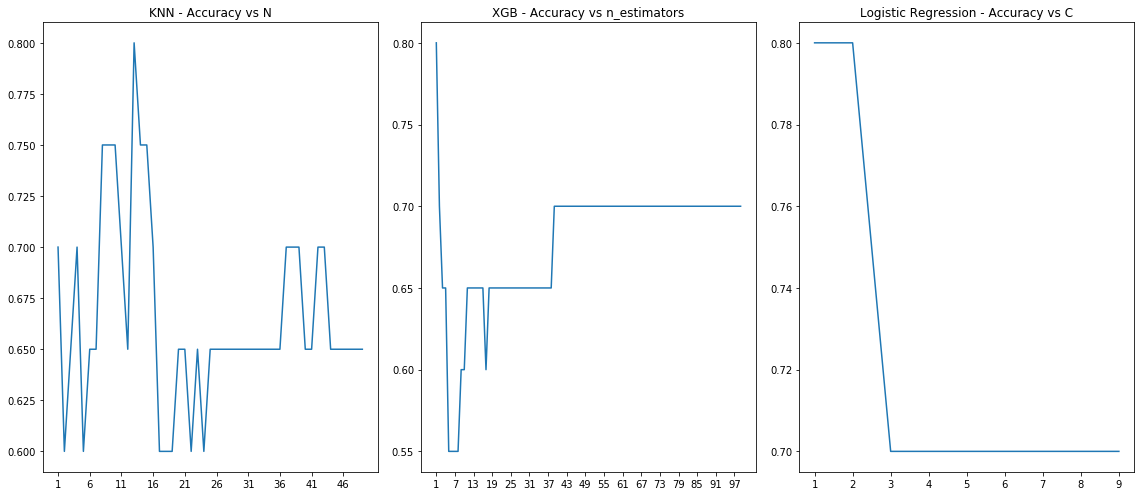

In [67]:
visualizeAccuracy()

In [68]:
max_knn_n = max(plot_scores_knn)
max_knn_ind = plot_scores_knn.index(max_knn_n)

max_XGB_e = max(plot_scores_XGB)
max_XGB_ind = plot_scores_XGB.index(max_XGB_e)

max_logreg_c = max(plot_scores_logreg)
max_logreg_ind = plot_scores_logreg.index(max_logreg_c)

In [69]:
print('knn, max accuracy: ', max_knn_n, 'index: ', max_knn_ind)
print('XGB', max_XGB_e, 'index: ', max_XGB_ind)
print('logRed', max_logreg_c, 'index: ', max_logreg_ind)

knn, max accuracy:  0.8 index:  12
XGB 0.8 index:  0
logRed 0.8 index:  0
